In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pvlib
import pandas as pd

In [2]:
class SingleAxisSolarEnv(gym.Env):
    def __init__(self, latitude, longitude, times):
        super(SingleAxisSolarEnv, self).__init__()
        self.latitude = latitude
        self.longitude = longitude
        self.times = times
        self.solpos = pvlib.solarposition.get_solarposition(
            self.times, self.latitude, self.longitude
        )

        self.fixed_azimuth = 180  # Panel menghadap ke selatan
        self.panel_elevation = 30  # Posisi awal elevasi panel

        # Aksi: 0 = turun, 1 = tetap, 2 = naik
        self.action_space = spaces.Discrete(3)

        # Observasi: [elevasi panel, elevasi matahari]
        self.observation_space = spaces.Box(
            low=np.array([0, -90], dtype=np.float32),
            high=np.array([90, 90], dtype=np.float32),
            dtype=np.float32,
        )

        self.current_step = 0

    def step(self, action):
        delta = [-2, 0, 2][action]
        self.panel_elevation = np.clip(self.panel_elevation + delta, 0, 90)

        elevation_sun = self.solpos["apparent_elevation"].iloc[self.current_step]
        azimuth_sun = self.solpos["azimuth"].iloc[self.current_step]

        angle = self.calculate_angle(
            azimuth_sun, elevation_sun, self.fixed_azimuth, self.panel_elevation
        )
        energy = max(np.cos(np.deg2rad(angle)), 0)
        reward = energy

        next_state = np.array([self.panel_elevation, elevation_sun], dtype=np.float32)
        done = self.current_step >= len(self.times) - 1
        self.current_step += 1

        return next_state, reward, done, False, {}

    def reset(self, seed=None, options=None):
        self.panel_elevation = 30
        self.current_step = 0
        elevation_sun = self.solpos["apparent_elevation"].iloc[self.current_step]
        state = np.array([self.panel_elevation, elevation_sun], dtype=np.float32)
        return state, {}

    def calculate_angle(self, azimuth_sun, elev_sun, azimuth_panel, elev_panel):
        azimuth_diff = np.deg2rad(azimuth_sun - azimuth_panel)
        angle = np.arccos(
            np.sin(np.deg2rad(elev_sun)) * np.sin(np.deg2rad(elev_panel))
            + np.cos(np.deg2rad(elev_sun))
            * np.cos(np.deg2rad(elev_panel))
            * np.cos(azimuth_diff)
        )
        return np.rad2deg(angle)


## MELATIH PPO

In [8]:
from stable_baselines3.common.env_checker import check_env

# 1. Lokasi dan Waktu
latitude, longitude = -6.8903889, 107.6101944   # Bandung
times = pd.date_range('2025-06-04', '2025-06-05', freq='1h', tz='Asia/Jakarta')

# Buat environment
env = SingleAxisSolarEnv(latitude, longitude, times)

# Cek validitas environment
check_env(env)


In [9]:
from stable_baselines3 import PPO

# Buat ulang environment
env = SingleAxisSolarEnv(latitude, longitude, times)

# Buat model PPO
model = PPO("MlpPolicy", env, verbose=1)

# Latih model
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 25       |
|    ep_rew_mean     | 0.0905   |
| time/              |          |
|    fps             | 1788     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25          |
|    ep_rew_mean          | 0.239       |
| time/                   |             |
|    fps                  | 1319        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.031429008 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [11]:
model.save("ppo_single_axis_solar")

## VISUALISASI HASIL

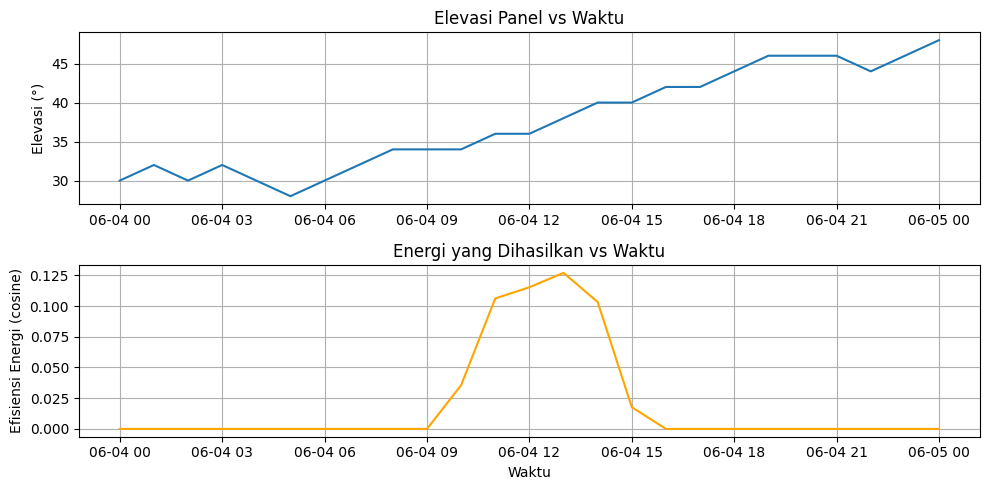

In [15]:
# Muat kembali model jika perlu
# model = PPO.load("ppo_single_axis_solar")

# Evaluasi agen
state, _ = env.reset()
states = []
rewards = []

for _ in range(len(times)):
    action, _ = model.predict(state)
    state, reward, done, _, _ = env.step(action)
    states.append(state[0])  # Elevasi panel
    rewards.append(reward)

# Visualisasi hasil
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(times, states, label='Elevasi Panel')
plt.ylabel("Elevasi (°)")
plt.title("Elevasi Panel vs Waktu")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(times, rewards, label='Reward (Energi)', color='orange')
plt.xlabel("Waktu")
plt.ylabel("Efisiensi Energi (cosine)")
plt.title("Energi yang Dihasilkan vs Waktu")
plt.grid(True)

plt.tight_layout()
plt.show()
